# <a class="anchor" id="0"></a>
# <center>Forest Cover Type Prediction</center>
# <center>PGP in AI & ML - AIML2020 Cohort 4, Group 1</center>
# <center>Capstone Project - PCAMZC321</center>

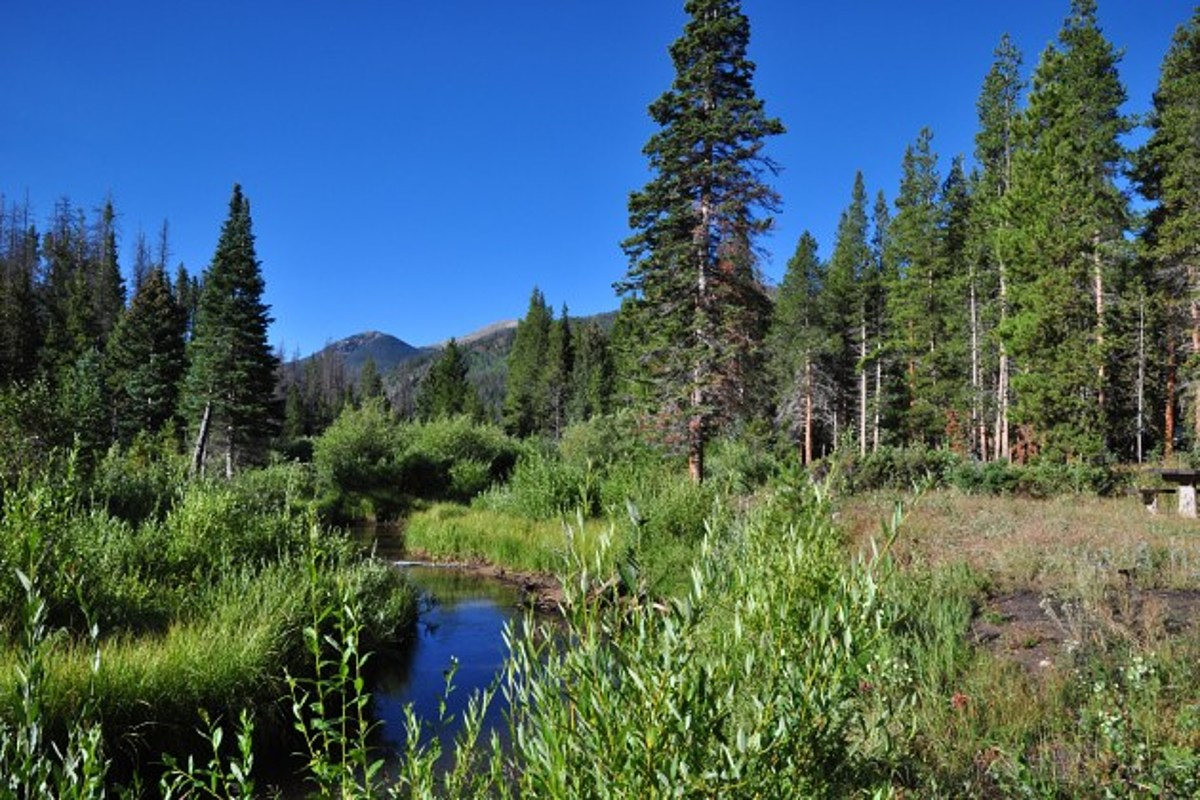

## Lead Instructor: 

    ## Mr. Satyaki Dasgupta

##  Student Names :

    ## Chandresh Khaneja | 2020AIML062 
    ## Saurabh Gupta     | 2020AIML065
    ## Sudheendran T L   | 2020AIML003
    ## Sudhir Valluri    | 2020AIML001


---
<a class="anchor" id="0"></a>
# **Table of Contents**

[1. Installation and Setup](#1)  
[2. Data Preparation](#2)  
[3. Data Visualizatipn](#3)  
[4. Modelling](#4)  
[5. Model Evaluation](#5)  
[6. References](#6)  

---

## **1. Installation and Setup** <a class="anchor" id="1"></a>

### Determine need to install packages this code depends on and installs them if not already installed

In [ ]:
try :
    from category_encoders import TargetEncoder
except:
    !pip install category_encoders

try :
    from imblearn.combine import SMOTETomek
except:
    !pip install imblearn

try :
    from plotly import graph_objects
except:
    !pip install plotly

try :
    from dython.nominal import associations
except:
    !pip install dython

try :
    import joblib
except:
    !pip install joblib
    
try :
    import missingno as msno
except:
    !pip install missingno
    
try:
    from lightgbm import LGBMClassifier
except:
    !pip install lightgbm
    
try:
    import pickle
except:
    !pip install pickle

try:
    from xgboost.sklearn import XGBClassifier
except:
    !pip install xgboost

### Import required libraries and modules

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
import time
import warnings

from category_encoders import TargetEncoder
from dython.nominal import associations
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier 
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from math import isnan
from numpy.random import uniform
from os.path import exists
from random import sample
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor, NearestNeighbors
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost.sklearn import XGBClassifier

warnings.filterwarnings("ignore")

### Setup some environment based configuration flags 

In [ ]:
try:

    from google.colab import drive

except:

    # this means that the environment is not google colab
    print("Running on a non-Colab environment...")

    # in the local environment, the current working directory is the path where data files are kept/writen to.
    #So, filepath is just the current directory
    filepath = "./"

    # in the local environment, we let no more than 1 CPU core to be engaged
    N_JOBS = 1
    
    # as compute, memory and storage resources are limited in the 
    # local environment, we use lesser volume of data to train the models
    TEST_SIZE = 0.8
    
else:

    # this means that the environment is google colab
    from psutil import virtual_memory

    print("Running on Google Colab environment...")
    
    # in the colab environment, lets mount the google drive where files are kept/written to
    # filepath is set to the path under google drive where files are kept/written to
    drive.mount('/drive')
    filepath = "/drive/My Drive/Colab Notebooks/"

    # in the colab environment, we engage all available CPU cores present in the virutal environment
    N_JOBS = -1

    # as compute, memory and storage resources are better in the Google
    # Colab environment, we use higher volume of data to train the models
    TEST_SIZE = 0.8

    # lets print some information about the virtual machine environment
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    print('Not connected to a GPU' if (gpu_info.find('failed') >= 0) else gpu_info)
    
    ram_gb = virtual_memory().total / 1e9
    print('Runtime has {:.1f} gigabytes of available RAM'.format(ram_gb))
    print('Not using a high-RAM runtime' if (ram_gb < 20 ) else 'Using a high-RAM runtime!')

In [ ]:
PROD = True

if ( PROD == True ):
    # In the production mode and hence we turn ON all developed features
    print("Running in production mode...")
    missing_data_analysis = True
    enable_hopkins_statistics = True
    display_visualizations = True
    redo_models = True
    
else:
    # In the debug mode and hence we conditinally turn ON features, as required
    print("Running in DEBUG mode...")
    missing_data_analysis = False
    enable_hopkins_statistics = False
    display_visualizations = False
    redo_models = False

### Setup some constants 

In [ ]:
class COLOR:
    BLUE = '\033[94m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

FORMATBBU = COLOR.BOLD + COLOR.BLUE + COLOR.UNDERLINE
FORMATBB = COLOR.BOLD + COLOR.BLUE
FORMATBR = COLOR.BOLD + COLOR.RED

# the baseline metric that we will use to compare and deterime if one model is better than the
# other or not. Valid/Supported values are: 'recall', 'precision' and 'f1-score'.
BASELINE_METRIC = 'recall'
#BASELINE_METRIC = 'precision'
#BASELINE_METRIC = 'f1-score'

[Go To Section Beginning](#1)    
[Go To Top](#0)

## **2. Data Pre-Processing** <a class="anchor" id="2"></a>

### Reading the forest cover type dataset present in "covtype.csv"

In [ ]:
# name columns based on https://bits-pilani.instructure.com/groups/17429/files/covtype.info 
org_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
        'Horizontal_Distance_To_Roadways', 'Hillshade_9am',  'Hillshade_Noon', 'Hillshade_3pm', 
        'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 
        'Wilderness_Area_4', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 
        'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 
        'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 
        'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 
        'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 
        'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40', 'Cover_Type']

org_df = pd.read_csv( filepath+"covtype.csv", index_col=False, names=org_cols)

### Inspect data of the forest cover type dataset

In [ ]:
org_df.head()

In [ ]:
org_df.tail()

In [ ]:
org_df.shape

In [ ]:
org_df.info(memory_usage = "deep")

In [ ]:
org_df.isnull().values.any()

In [ ]:
org_df.duplicated().values.any()

In [ ]:
org_df.describe().T

### 1) We see that there are no duplicates in the input data!
### 2) We see that the minimum value for Vertical_Distance_To_Hydrology is negative. After reviewing this closely, it was found that it is quite possible that water sources could be higher than the 30mx30m patch and is therefore not an anamoly. 
### 3) In addition, from the descriptive statistics above, there seem to be no other anamolies present in the given input data.
### 4) We see that every column has all the 581012 values in them and hence there are no missing or NULL values in the data given!
### 5) We see that the input data provided contains only integers and the maximum value across all columns is just 7173. We see that the dataframe consumes around 250MB of memory space! For performance reasons, we will go ahead and change column data types to the most optimal ones, good enough to accommodate the values. 

In [ ]:
def optimizeDataFrameSize(df, silent=True):
    
    if ( silent == False ):
        print("Dataframe memory footprint before optimization...")
        print(format(df.memory_usage().sum(),','))

    for col in df:

        if ( df[col].dtype == 'object' ) :
            # no further optimization possible on object memory
            continue

        if ( df[col].dtype == 'int64' ) :
            
            inttype = 'int16'
            if ( df[col].max() <= 255 ):
                inttype = 'int8'
            df[col] = df[col].astype(inttype)

    if ( silent == False ):
        print("Dataframe memory footprint after optimization...")
        print(format(df.memory_usage().sum(),','))
    
    return df

In [ ]:
org_df = optimizeDataFrameSize(org_df, False)

### A massive ~85% reduction in the memory footprint required for the dataframe has been achieved. This is critical, as we are going to copy/derive many more variants of this dataframe, during the data processing stages. Also, all dataframe operations will run faster now. Given the huge number of 500k observations in the dataframe, this reduction will go a long way in boosting model performance as well.

### We see that the Wilderness_Area and Soil_Type columns are One-Hot encoded in the input.  These two features themselves amount to 44 out of the 55 columns in the dataset! Let's reverse one-hot encode, and then do TargetEncoding instead, as the data is nominal in nature and hence LabelEncoding is not suited.

In [ ]:
def createCatData(data, cols):
    df = data.copy()
    df['Wilderness_Area'] = (df.iloc[:, 10:14] == 1).idxmax(axis='columns')
    df['Soil_Type'] = (df.iloc[:, 14:54] == 1).idxmax(axis='columns')
    df = df.reindex(columns = cols)
    return optimizeDataFrameSize(df)

In [ ]:
numcols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am',  'Hillshade_Noon', 'Hillshade_3pm', 
           'Horizontal_Distance_To_Fire_Points']

catcols = ['Soil_Type', 'Wilderness_Area']
ycols = ['Cover_Type']
xcols = numcols+catcols
cols = xcols+ycols

In [ ]:
# rename columns based on the categorical nature of the columns
cat_df = createCatData(org_df, cols)

In [ ]:
cat_df.head()

In [ ]:
cat_df.tail()

In [ ]:
cat_df.shape

In [ ]:
cat_df.info(memory_usage = "deep")

In [ ]:
cat_df.isnull().values.any()

In [ ]:
cat_df.duplicated().values.any()

In [ ]:
cat_df.describe().T

### Lets target encode the categorical columns

In [ ]:
def createTargetEncData(data, cols, target):
    df = data.copy()
    for col in cols: df[col] = TargetEncoder().fit_transform(df[col], df[target])
    return optimizeDataFrameSize(df)

In [ ]:
enc_df = createTargetEncData(cat_df, catcols, ycols)

In [ ]:
enc_df.head()

In [ ]:
enc_df.tail()

In [ ]:
enc_df.shape

In [ ]:
enc_df.isnull().values.any()

In [ ]:
enc_df.duplicated().values.any()

In [ ]:
enc_df.describe().T

### Though the input data does NOT have missing values, NaN etc, we will introduce some missing values, for study/learning purposes. Simple Mean imputation is not effective and hence imputations like MICE (Multivariate Imputation by Chained Equations) or kNN will be better. We will use MICE imputation here 

In [ ]:
def addMissingData(data, percent):
    df = data.copy()
    
    for col in df.columns:
        df[col] = df[col].astype("float")
        
    # Let's add missing values in the input data at random rows, across all columns, except the target column
    count = int(df.shape[0] * percent / 100)
    for i in range(count):
        random_row = random.randint(0,df.shape[0]-1)
        random_col = random.randint(0,df.shape[1]-2)
        df.iat[random_row,random_col] = np.nan

    
    # display visualization on missing data
    msno.matrix(df,color=(0, 0, 0));
    plt.show()
    
    msno.bar(df,color=(0, 0, 0));
    plt.show()
    
    plt.subplots(figsize=(15,15))
    plt.title("Missing Values Distribution")
    plt.xlabel("Count")
    sns.barplot(y=df.isnull().columns, x=df.isnull().sum(), color="blue");
    plt.show()
    
    return df

def miceImputeMissingData(df, cols):
    # Perform MICE imputation
    imputer = IterativeImputer(estimator=LinearRegression(), missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman', random_state=0)
    df = imputer.fit_transform(df)
    return pd.DataFrame(df, columns=cols)

In [ ]:
if ( missing_data_analysis == True ):
    # Lets add 10% missing data in the data 
    em_df = addMissingData(enc_df, 10)
    em_df.isnull().values.any()

In [ ]:
if ( missing_data_analysis == True ):
    # And impute the missing data!
    em_df = miceImputeMissingData(em_df, cols)
    em_df.isnull().values.any()

### We have successfully imputed all the missing data!

### Let's now analyse the data for outliers. Using univariate z-score outlier techniques may NOT be effective and hence we use Local Outlier Factor (LOF) algorithm to detect and remove outliers. Also data preprocessing steps like outlier removal, scaling, SMOTE and PCA are done ONLY on the training data and NOT on the test/validation data. We will go ahead and drop the outlier rows found by LOF algorithm

In [ ]:
x = org_df.iloc[:, :-1]
y = org_df.iloc[:, org_df.shape[1]-1]
org_xtrain, org_xtest, org_ytrain, org_ytest = train_test_split(x, y, test_size = TEST_SIZE, random_state=42, stratify=y)
org_ytrain = pd.DataFrame(org_ytrain, columns=['Cover_Type'])
org_ytest = pd.DataFrame(org_ytest, columns=['Cover_Type'])

In [ ]:
x = enc_df.iloc[:, :-1]
y = enc_df.iloc[:, enc_df.shape[1]-1]
enc_xtrain, enc_xtest, enc_ytrain, enc_ytest = train_test_split(x, y, test_size = TEST_SIZE, random_state=42, stratify=y)
enc_ytrain = pd.DataFrame(enc_ytrain, columns=['Cover_Type'])
enc_ytest = pd.DataFrame(enc_ytest, columns=['Cover_Type'])

In [ ]:
def removeLOFOutliers(x, y, target):
    xo = x.copy()
    yo = y.copy()
    xo['ClusterPred'] = LocalOutlierFactor().fit_predict(xo)
    print(xo['ClusterPred'].value_counts())

    o_rows = xo[ xo['ClusterPred'] == -1 ].index

    if (len(o_rows) > 0 ):
        xo.drop(o_rows, inplace=True)
        xo.reset_index(drop=True, inplace=True)
        yo.drop(o_rows, inplace=True)
        yo.reset_index(drop=True, inplace=True)
        yo = pd.DataFrame(yo, columns=[target])

    xo.drop(['ClusterPred'], axis=1, inplace=True)
    
    return optimizeDataFrameSize(xo), yo, len(o_rows)

In [ ]:
eo_xtrain, eo_ytrain, removed = removeLOFOutliers(enc_xtrain, enc_ytrain, 'Cover_Type')

In [ ]:
eo_xtrain.shape, eo_ytrain.shape

### We have successfully removed all outliers!

### Now let's check for class imbalance in the input data

In [ ]:
plt.subplots(figsize=(15,15))
plt.title("Target Class Distribution")
plt.xlabel("Target Class")
plt.ylabel("Frequency")
sns.countplot(x="Cover_Type", data=eo_ytrain, palette="bright")
plt.show()

plt.subplots(figsize=(15,15))
sns.scatterplot(eo_xtrain['Elevation'], eo_xtrain['Aspect'], hue=eo_ytrain['Cover_Type'], palette="bright");
plt.show()

### There is clearly an imbalance of target class data present in the input data. Spruce/Fir and Lodgepole Pine data is >85% of the total data! Let's apply SMOTE to counter the imbalance

In [ ]:
def performSMOTETomek(x,y, xols, ycols):
    smote = SMOTETomek( random_state = 42 )
    bx, by = smote.fit_resample(x, y)
    bx = pd.DataFrame(bx, columns=xcols)
    by = pd.DataFrame(by, columns=ycols)
    bx.reset_index(drop=True, inplace=True)
    by.reset_index(drop=True, inplace=True)
    print(bx.shape)
    print(by.shape)

    # check for duplicated rows and remove barring first occurrence
    #print(sum(bx.duplicated().values))
    d_rows = bx.loc[bx.duplicated()==True].index
    bx.drop(d_rows, inplace=True)
    bx.reset_index(drop=True, inplace=True)
    by.drop(d_rows, inplace=True)
    by.reset_index(drop=True, inplace=True)
    bx = pd.DataFrame(bx, columns=xcols)
    by = pd.DataFrame(by, columns=ycols)

    print(len(d_rows))

    return optimizeDataFrameSize(bx), by

In [ ]:
eob_xtrain, eob_ytrain = performSMOTETomek(eo_xtrain, eo_ytrain, xcols, ycols)

In [ ]:
eob_xtrain.shape, eob_ytrain.shape

In [ ]:
plt.subplots(figsize=(15,15))
plt.title("Target Class Distribution")
plt.xlabel("Target Class")
plt.ylabel("Frequency")
sns.countplot(x="Cover_Type", data=eob_ytrain, palette="bright")
plt.show()

plt.subplots(figsize=(15,15))
sns.scatterplot(eob_xtrain['Elevation'], eob_xtrain['Aspect'], hue=eob_ytrain['Cover_Type'], palette="bright");
plt.show()

### The data is very much balanced, after the application of SMOTE!

### We will now BIN the numerical columns, as such BINning might help some algorithms perform better

In [ ]:
def createBinnedData(df, cols):
    binx = df.copy()
    for col in cols: binx[col] = pd.qcut(binx[col], 10, labels=False)
    return optimizeDataFrameSize(binx)

In [ ]:
eobbin_xtrain = createBinnedData(eob_xtrain, numcols)

In [ ]:
eobbin_xtrain.head()

In [ ]:
eobbin_xtrain.describe().T

### Lets scale the input data. We will use both Min-Max and Standard scaling techniques, as both have pros and cons. With Min-Max we avoid negative values and hence might suit some algorithms better. With Standard Scaler, as the scaled data will be gaussian normal, it will suit some algorithms better.

In [ ]:
def minMaxScaleData (df, cols):
    msdf = df.copy()
    msdf = MinMaxScaler().fit_transform(msdf)
    return optimizeDataFrameSize(pd.DataFrame(msdf, columns = cols))

In [ ]:
def stdScaleData (df, cols):
    ssdf = df.copy()
    ssdf = StandardScaler().fit_transform(ssdf)
    return optimizeDataFrameSize(pd.DataFrame(ssdf, columns = cols))

In [ ]:
eobms_xtrain = minMaxScaleData(eob_xtrain, xcols)
eobms_xtrain.head()

In [ ]:
eobss_xtrain = stdScaleData(eob_xtrain, xcols)
eobss_xtrain.head()

### Though the input features are just 12, for some algorithms, this may still pose a performance challenge. Hence, we will perform PCA to achieve dimensionality reduction and use such a reduced data for those algorithms

In [ ]:
def performPCA (x, cols):
    pcax = PCA(svd_solver='randomized', random_state=42)
    pcax.fit(x)
    print(pcax.components_)
    
    #Plot the cumulative variance against the number of components
    fig = plt.figure(figsize = (15,15))
    plt.plot(np.cumsum(pcax.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Scree Plot')
    plt.grid()
    plt.show()
    
    return pd.DataFrame({'PC1':pcax.components_[0],'PC2':pcax.components_[1], 'Feature':xcols})

In [ ]:
eopca_xtrain = performPCA(eo_xtrain, xcols)
eopca_xtrain

In [ ]:
fig = plt.figure(figsize = (15,15))
plt.scatter(eopca_xtrain.PC1, eopca_xtrain.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(eopca_xtrain.Feature):
    plt.annotate(txt, (eopca_xtrain.PC1[i],eopca_xtrain.PC2[i]))
plt.tight_layout()
plt.show()

### Based on the visual interpretation above, we see that 3 components are sufficient to best describe about 90% of the variance in the dataset

In [ ]:
def performIncrementalPCA(xtrain, xtest):
    pca_final = IncrementalPCA(n_components=3)
    pxtrain = pca_final.fit_transform(xtrain)
    pxtest = pca_final.fit_transform(xtest)
    return optimizeDataFrameSize(pd.DataFrame(pxtrain)), optimizeDataFrameSize(pd.DataFrame(pxtest))

In [ ]:
#Using incremental PCA for better efficiency
eopca_xtrain, encpca_xtest = performIncrementalPCA(eo_xtrain, enc_xtest)

In [ ]:
eopca_xtrain.head()

In [ ]:
encpca_xtest.head()

In [ ]:
corrmat = np.corrcoef(eopca_xtrain.transpose())
plt.figure(figsize=(15,15))
sns.heatmap(corrmat, square=True, annot=True, fmt='.6%', cmap="RdYlGn")
plt.show()

### As our problem is to predict the class of forest cover types, so let's check if the input data inherently has clusters present in it

In [ ]:
def hopkins(X):
    d = X.shape[1]
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [ ]:
if (enable_hopkins_statistics == True):
    print(hopkins(enc_xtrain))

### Conclusion :
### Hopkins score <=0.5 : Indicates Low Clustering Tendency in the data
### Hopkins score >0.5   : Indicates High Clustering Tendency in the data
### As Hopkins score obtained is ~0.9, the input data has strong presence of clusters

[Go To Section Beginning](#2)  
[Go To Installation and Setup](#1)  
[Go To Top](#0)

## **3. Data Visualization** <a class="anchor" id="3"></a>

In [ ]:
if ( display_visualizations == True ):
    _, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
    
    for idx, col in enumerate(numcols):
        i = idx % 5
        j = idx // 5
        sns.distplot(cat_df[col], ax=ax[i][j])
        ax[i][j].text(x=0.97, y=0.97, transform=ax[i][j].transAxes, s="Skewness: %f" % cat_df[col].skew(),\
                      fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')
        ax[i][j].text(x=0.97, y=0.87, transform=ax[i][j].transAxes, s="Kurtosis: %f" % cat_df[col].kurt(),\
                      fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right')

In [ ]:
soil_order = ['Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 
              'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10','Soil_Type_11', 'Soil_Type_12', 
              'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 
              'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 
              'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 
              'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36',
              'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Soil_Type_40']

if ( display_visualizations == True ):
    plt.figure(figsize=(15,15))
    sns.countplot(y="Soil_Type", data=cat_df, palette="bright", order=soil_order)
    plt.show()
    
    plt.figure(figsize=(15,15))
    sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=cat_df, palette="bright")
    plt.show()

In [ ]:
if ( display_visualizations == True ):
    _, ax = plt.subplots(nrows=10, ncols=2, figsize=(15, 50))
    for idx, col in enumerate(numcols):
        sns.boxplot(x=col, data=cat_df, color="peachpuff", ax=ax[idx][0])
        sns.violinplot(x=col, data=cat_df, color="peachpuff", ax=ax[idx][1] )

In [ ]:
plt.rcParams["figure.figsize"] = (15,15)

def elevation_multiple_covtype_distplot(elevations_df, covtype_mapping):
    '''Plot an Elevation's histogram for each Cover Type on the same figure'''

    # Color palette for distplot
    custom_palette = ['#F97EDB', '#49C0EA', '#B49EFC', '#CDAB40',
                      '#F69089', '#76BF3F', '#4CC9A6']

    # Set distplot background
    sns.set_style('darkgrid')
    
    # Custom bins range for evenly spaced hists
    bins = range(1800,4000,60)
    
    # Iterate through the dictionary to plot a histogram for each cover type
    for covtype_id, covtype_name in covtype_mapping.items():

        # covtype_id goes from 1 to 7
        # thus subtract 1 for indexing custom_palette
        palette_idx = covtype_id - 1
        
        # Create a group for each Cover_Type and return a df satisfying the condition
        # on Cover_Type column
        by_one_covtype = elevations_df.groupby('Cover_Type').apply(lambda x: x[ x['Cover_Type'] == covtype_id ])
        # Plot one Elevation histogram for one group
        ax = sns.distplot(by_one_covtype.Elevation,
                          bins=bins,
                          color=custom_palette[palette_idx], label=covtype_name,
                          hist_kws=dict(alpha=0.8, edgecolor="none"),
                          kde=False)

    # Legend position to upper right
    plt.legend(loc='right', bbox_to_anchor=(1.2, 0.8), ncol=1)
    
    # Apply proper labeling to the axes
    ax.set(xlabel='Elevation (meters)', ylabel='Count')

    # Avoid cutting off the legend from the figure
    plt.tight_layout()

    # Show the figure (can be omitted in Jupyter Notebooks)
    plt.show()

In [ ]:
# Plot an Elevation's histogram for each Cover Type to check for possible class separation

# Slice by two columns: Elevation and Cover_Type
elevations = cat_df.loc[:, ['Elevation', 'Cover_Type']]

# Dictionary for mapping each integer target label to its string value
covtype_label_name_dict = {1: 'Spruce/Fir',
                           2: 'Lodgepole Pine',
                           3: 'Ponderosa Pine',
                           4: 'Cottonwood/Willow',
                           5: 'Aspen',
                           6: 'Douglas-fir',
                           7: 'Krummholz'}

# It is clear that classes 4 (Willow), 5 (Aspen) and 7 (Krummholz) are easily separable
if ( display_visualizations == True ):
    elevation_multiple_covtype_distplot(elevations, covtype_label_name_dict)

In [ ]:
if ( display_visualizations == True ):
    sns.set(font_scale=1.25)
    associations(cat_df, figsize=(15, 15),annot=True, fmt='.0%',cmap="RdYlGn");

In [ ]:
if ( display_visualizations == True ):
    f, ax = plt.subplots(figsize=(15,15))
    sns.set(font_scale=1.25)
    sns.heatmap(cat_df.corr(),square=True, annot=True, fmt='.0%',cmap="RdYlGn");
    plt.show()

In [ ]:
if ( display_visualizations == True ):
    g = sns.pairplot(cat_df[xcols])
    g.fig.set_size_inches(25,25)
    plt.show()

In [ ]:
kd_list = [
    ("Elevation", "Cover_Type"), 
    ("Aspect", "Cover_Type"), 
    ("Slope", "Cover_Type"), 
    ("Horizontal_Distance_To_Hydrology", "Cover_Type"), 
    ("Vertical_Distance_To_Hydrology", "Cover_Type"), 
    ("Horizontal_Distance_To_Roadways", "Cover_Type"), 
    ("Hillshade_9am", "Cover_Type"), 
    ("Hillshade_Noon", "Cover_Type"), 
    ("Hillshade_3pm", "Cover_Type"), 
    ("Horizontal_Distance_To_Fire_Points", "Cover_Type"), 
]

if ( display_visualizations == True ):
    for (x, hue) in kd_list:
        sns.kdeplot(data=cat_df,x=x,hue=hue,multiple='stack',palette="bright")
        plt.show()

In [ ]:
jp_list = [
    ("Elevation", "Aspect", "Cover_Type"), 
    ("Elevation", "Aspect", "Wilderness_Area"), 
    ("Elevation", "Aspect", "Soil_Type"), 
    ("Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Cover_Type"), 
    ("Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", "Wilderness_Area"), 
]

if ( display_visualizations == True ):
    for (x, y, hue) in jp_list:
        sns.jointplot(data=cat_df, x=x, y=y,hue=hue,palette="bright",height=15)

In [ ]:
if ( display_visualizations == True ):
    _, ax = plt.subplots(nrows=10, ncols=2, figsize=(15, 50))
    
    for idx, col in enumerate(numcols):
        sns.boxplot(y=col, x=ycols[0], data=cat_df, palette="bright", ax=ax[idx][0],)
        sns.violinplot(y=col, x=ycols[0], data=cat_df, color=".8", ax=ax[idx][1], palette="bright")

In [ ]:
fg_list = [
    ("Soil_Type", "Cover_Type", "Elevation", "Aspect"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Slope"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Horizontal_Distance_To_Hydrology"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Vertical_Distance_To_Hydrology"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Horizontal_Distance_To_Roadways"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Hillshade_9am"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Hillshade_Noon"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Hillshade_3pm"), 
    ("Soil_Type", "Cover_Type", "Elevation", "Horizontal_Distance_To_Fire_Points"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Aspect"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Slope"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Horizontal_Distance_To_Hydrology"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Vertical_Distance_To_Hydrology"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Horizontal_Distance_To_Roadways"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Hillshade_9am"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Hillshade_Noon"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Hillshade_3pm"), 
    ("Wilderness_Area", "Cover_Type", "Elevation", "Horizontal_Distance_To_Fire_Points"), 
]

if ( display_visualizations == True ):
    for (row, hue, param1, param2) in fg_list:
        g = sns.FacetGrid(cat_df, row=row, hue=hue, legend_out=True, height=10, palette="bright")
        g.map(sns.scatterplot, param1, param2, palette="bright")

In [ ]:
hb_list = [
    ("Aspect", "Elevation"), 
    ("Aspect", "Slope"), 
    ("Aspect", "Horizontal_Distance_To_Hydrology"), 
    ("Aspect", "Vertical_Distance_To_Hydrology"), 
    ("Aspect", "Horizontal_Distance_To_Roadways"), 
    ("Aspect", "Hillshade_9am"), 
    ("Aspect", "Hillshade_Noon"), 
    ("Aspect", "Hillshade_3pm"), 
    ("Aspect", "Horizontal_Distance_To_Fire_Points"), 
]

if ( display_visualizations == True ):
    for (x, y) in hb_list:
        cat_df.plot.hexbin(x=x, y=y,gridsize=10, cmap="viridis", sharex=False,figsize=(8,6))

[Go To Section Beginning](#3)  
[Go To Data Preprocessing](#2)  
[Go To Installation and Setup](#1)  
[Go To Top](#0)

## **4. Modelling** <a class="anchor" id="4"></a>

### We now have the original input dataframe and many other dataframes as a result of various pre processing activities done above. Here is a list of the various dataframes and description of the same.

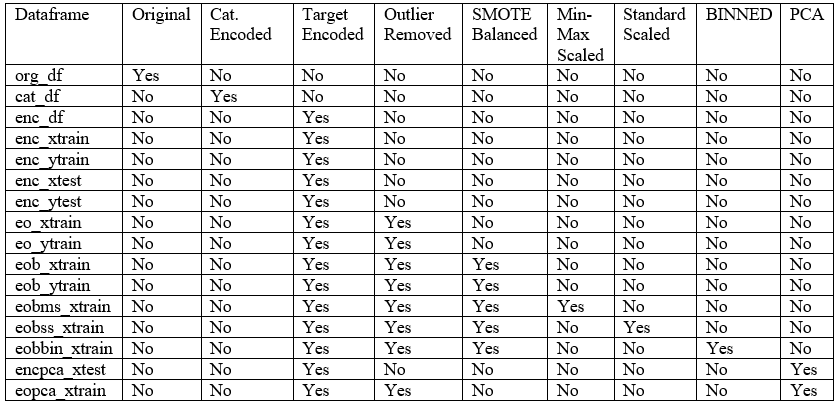

In [ ]:
df_list = [
    ("Org Data", org_xtrain.copy(), org_xtest.copy(), org_ytrain.values.ravel(), org_ytest.values.ravel()), 
    ("Target Enc Data", enc_xtrain.copy(), enc_xtest.copy(), enc_ytrain.values.ravel(), enc_ytest.values.ravel()), 
    ("No Outliers Data", eo_xtrain.copy(), enc_xtest.copy(), eo_ytrain.values.ravel(), enc_ytest.values.ravel()), 
    ("Balanced Data", eob_xtrain.copy(), enc_xtest.copy(), eob_ytrain.values.ravel(), enc_ytest.values.ravel()), 
    ("MinMax Scaled Data", eobms_xtrain.copy(), enc_xtest.copy(), eob_ytrain.values.ravel(), enc_ytest.values.ravel()),
    ("Std Scaled Data", eobss_xtrain.copy(), enc_xtest.copy(), eob_ytrain.values.ravel(), enc_ytest.values.ravel()), 
    ("Binned Data", eobbin_xtrain.copy(), enc_xtest.copy(), eob_ytrain.values.ravel(), enc_ytest.values.ravel()), 
    ("PCA Data", eopca_xtrain.copy(), encpca_xtest.copy(), eo_ytrain.values.ravel(), enc_ytest.values.ravel()), 
]

In [ ]:
for (df_name, xtrain, xtest, ytrain, ytest) in df_list:
    print(df_name, xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

In [ ]:
pipeline_parameters = [ 

    (
        Pipeline([('CNB', ComplementNB())]), {
            'CNB__alpha': [0, 1],
            }
    ),
    
    (
        Pipeline([('DTC', DecisionTreeClassifier())]), {
            'DTC__criterion': ['gini', 'entropy'],
            'DTC__random_state': [42],
            }
    ),
    
    (
        Pipeline([('ETC', ExtraTreesClassifier())]), {
            'ETC__n_estimators': [100],
            'ETC__criterion': ['gini'],
            'ETC__n_jobs': [N_JOBS],
            'ETC__random_state': [42],
            }
    ),

    (
        Pipeline([('GNB', GaussianNB())]), {
            'GNB__var_smoothing': [1e-8, 1e-9],
            }
    ),

    (
        Pipeline([('kNN', KNeighborsClassifier())]), {
            'kNN__n_neighbors': [5],
            'kNN__n_jobs': [N_JOBS],
            }
    ),

    (
        Pipeline([('LGBM', LGBMClassifier())]), {
            'LGBM__n_estimators': [100],
            'LGBM__random_state': [42],
            'LGBM__n_jobs': [N_JOBS],
            }
    ),

    (
        Pipeline([('LDA', LinearDiscriminantAnalysis())]), {
            'LDA__tol': [1e-4],
            }
    ),

    (
        Pipeline([('LSVC', LinearSVC())]), {
            'LSVC__random_state': [42],
            }
    ),

    (
        Pipeline([('LR', LogisticRegression())]), { 
            'LR__tol': [1e-4],
            'LR__random_state': [42],
            'LR__n_jobs': [N_JOBS],
            }
    ),

    (
        Pipeline([('MLP', MLPClassifier())]), {
            'MLP__activation': ['relu'],
            'MLP__solver': ['adam'],
            'MLP__random_state': [42],
            'MLP__early_stopping': [True],
            }
    ),

    (
        Pipeline([('MNB', MultinomialNB())]), {
            'MNB__alpha': [0, 1],
            }
    ),

    (
        Pipeline([('QDA', QuadraticDiscriminantAnalysis())]), {
            'QDA__tol': [1e-4],
            }
    ),

    (
        Pipeline([('RFC', RandomForestClassifier())]), {
            'RFC__criterion': ['gini'],
            'RFC__n_jobs': [N_JOBS],
            'RFC__random_state': [42],
            }
    ),

    (
        Pipeline([('RIDGE', RidgeClassifier())]), {
            'RIDGE__tol': [1e-4],
            'RIDGE__random_state': [42],
            }
    ),

    (
        Pipeline([('RCV', RidgeClassifierCV())]), {
            'RCV__cv': ["None", 5],
            }
    ),

    (
        Pipeline([('SGD', SGDClassifier())]), {
            'SGD__max_iter': [1000],
            'SGD__shuffle': [True],
            'SGD__n_jobs': [N_JOBS],
            'SGD__random_state': [42],
            'SGD__early_stopping': [True],
            }
    ),

    (
        Pipeline([('XGB', XGBClassifier())]), {
            'XGB__n_estimators': [100],
            'XGB__n_jobs': [N_JOBS],
            'XGB__eval_metric': ['mlogloss'],
            'XGB__random_state': [42],
            }
    ),

]

In [ ]:
models_df = []
models_mlist = []
best_of_best_metric = 0
best_algo_count = 0
best_algos_list = []
best_of_best_algorithm = "TBC"
best_of_best_df_name = "TBC"
best_of_best_model = 0
best_of_best_ytest = []
best_of_best_ypredict = []

for (df_name, xtrain, xtest, ytrain, ytest) in df_list:
    
    # Iterate through all different types of datasets that we have
    print(FORMATBB+'======================== New Dataset ========================================='+COLOR.END)
    print(time.strftime("%Y-%m-%d %H:%M:%S"))
    print(df_name)
    
    model_df = pd.DataFrame()

    for pipeline, parameters in pipeline_parameters:

        # Iterate through all different models in the pipeline built
        try:
            print(FORMATBB+'======================== New Model ========================================='+COLOR.END)
            print('Starting RandomizedSearch for', pipeline[0])
            print(time.strftime("%Y-%m-%d %H:%M:%S"))
            start = time.time()

            # Create the file name for the model/dataset combination
            name = pipeline.steps[0][0] + "-" + df_name
            mfile_name = filepath + name + ".sav"
            cfile_name = filepath + name + ".cr"
            if ( exists ( mfile_name ) and exists ( cfile_name ) and ( redo_models == False ) ):
                print("This model and classification report has been already generated! Not re-doing...")
                continue

            # Using RandomizedSearchCV to limit to a maximum of 10 parametric combinations in the pipeline
            k_fold = StratifiedKFold(shuffle=True, random_state=42)
            model = RandomizedSearchCV(pipeline, param_distributions=parameters, n_jobs=N_JOBS, cv=k_fold, n_iter=10, verbose=2, random_state=42)

            # Fit the model and Predict using it
            model.fit(xtrain, ytrain)
            ypredict = model.predict(xtest)

            print("The best score obtained is: ", f"{100*model.best_score_:.2f}%")
            print("The best score is obtained with parameters : ", model.best_params_)
            print("---------- Classification Report ----------")
            print(classification_report(ytest, ypredict))

            # Save this model for future use
            with open(mfile_name, "wb") as file:
                print("Saving model binary ", mfile_name)
                pickle.dump(model.best_estimator_[0],file)
            with open(cfile_name, "w") as file:
                print("Saving classification report ", cfile_name)
                file.write(classification_report(ytest, ypredict))

            # The model did not classify test data into all possible output classes!
            if ( len(np.unique(ypredict)) != len(np.unique(ytest)) ):
                print("Poor prediction : Only {} of all possible 7 classes present in ypredict!".format(str(len(np.unique(ypredict)))))
                continue

            # Add this model for cross comparison between models
            model_df[name] = ypredict

            # Save the recall for every class predicted and accuracy scores
            cr = classification_report(ytest, ypredict,output_dict=True)
            df = pd.DataFrame(cr).transpose()
            mlist = [ round(df[BASELINE_METRIC][idx],2) for idx in range (len(np.unique(ypredict))) ]
            models_mlist.append((name, mlist))

            # The model did not perform better than the earlier found best model!
            if ( min(mlist) <= best_of_best_metric ) :
                print("We've encountered better {} metrics of {} with earlier models...".format(BASELINE_METRIC, best_of_best_metric))
                continue

            # A new model candidate has been identified which is progressively better than
            # earlier encountered model candidates
            best_algo_count = best_algo_count + 1
            print("This baseline metric used was {}; the score obtained was {}".format(BASELINE_METRIC, min(mlist)))
            best_algos_list.append((best_algo_count, pipeline[0], df_name, mlist, model.best_estimator_[0], ytest, ypredict))
            best_of_best_algorithm = pipeline[0]
            best_of_best_ytest = ytest
            best_of_best_ypredict = ypredict
            best_of_best_model = model.best_estimator_[0]
            best_of_best_df_name = df_name
            best_of_best_metric = min(mlist)

        except Exception as e:
            print(FORMATBR+'!!!!!!!!!!!!!!!!!!!!!!!! Exception Encountered !!!!!!!!!!!!!!!!!!!!!!!!'+COLOR.END)
            print("Exception details - "+ str(pipeline[0]) + " : " + str(e) )

        finally :
            end = time.time()           
            print("Elapsed time for model execution : ", time.strftime('%Hh:%Mm:%Ss', time.gmtime(end-start)))
            print("Thus far found {} good model candidate(s)...".format(best_algo_count))
            print("The model {}, dataset '{}' is the best as yet!".format(best_of_best_algorithm, best_of_best_df_name))

    models_df.append(model_df)

print("Across all models & datasets, found {} good candidate(s)...".format(best_algo_count))

In [ ]:
# Let's create an ensemble of the top 3 models encountered thus far
estimator = []
estimator.append(('ETC', ExtraTreesClassifier(n_jobs=N_JOBS)))
estimator.append(('kNN', KNeighborsClassifier(n_jobs=N_JOBS)))
estimator.append(('LGBM', LGBMClassifier(n_jobs=N_JOBS)))

xtrain = eob_xtrain.copy()
xtest = enc_xtest.copy()
ytrain = eob_ytrain.values.ravel()
ytest = enc_ytest.values.ravel()

# First lets do a hard voting, with equal weightage for all 3 models
vmodel = VotingClassifier(estimators=estimator, voting='hard')
vmodel = vmodel.fit(xtrain, ytrain)
ypredict = vmodel.predict(xtest)
cr = classification_report(ytest, ypredict)
print("Classification report with hard voting\n", cr)

mfile_name = filepath + "V-HARD-ETC-kNN-LGBM" + "-Balanced Data.sav"
cfile_name = filepath + "V-HARD-ETC-kNN-LGBM" + "-Balanced Data.cr"
with open(mfile_name, "wb") as file:
    print("Saving voting model ", mfile_name)
    pickle.dump(vmodel,file)
with open(cfile_name, "w") as file:
    print("Saving voting model classification report ", cfile_name)
    file.write(cr)

# Now lets do a soft voting, with equal weightage for all 3 models
vmodel = VotingClassifier(estimators=estimator, voting='soft', weights=[1,1,1])
vmodel = vmodel.fit(xtrain, ytrain)
ypredict = vmodel.predict(xtest)
cr = classification_report(ytest, ypredict)
print("Classification report with soft 1:1:1 voting\n", cr)

mfile_name = filepath + "V-SOFT111-ETC-kNN-LGBM" + "-Balanced Data.sav"
cfile_name = filepath + "V-SOFT111-ETC-kNN-LGBM" + "-Balanced Data.cr"
with open(mfile_name, "wb") as file:
    print("Saving voting model ", mfile_name)
    pickle.dump(vmodel,file)
with open(cfile_name, "w") as file:
    print("Saving voting model classification report ", cfile_name)
    file.write(cr)

print(FORMATBBU+"\n---------- Confusion Matrix ----------"+COLOR.END)
cm = confusion_matrix(ytest, ypredict)
print(cm)

print(FORMATBBU+"\n---------- Confusion Matrix - Graphical ----------"+COLOR.END)
f, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cm, square=True, annot=True, fmt="d", cmap="RdYlGn");
plt.show()
    
f, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cm/np.sum(cm), square=True, annot=True, fmt='.2%', cmap='RdYlGn')
plt.show()

# Now lets do a soft voting, with 2:1:1 weightage for ETC, kNN and LGBM respectively
vmodel = VotingClassifier(estimators=estimator, voting='soft', weights=[2,1,1])
vmodel = vmodel.fit(xtrain, ytrain)
ypredict = vmodel.predict(xtest)
cr = classification_report(ytest, ypredict)
print("Classification report with soft 2:1:1 voting\n", cr)

mfile_name = filepath + "V-SOFT211-ETC-kNN-LGBM" + "-Balanced Data.sav"
cfile_name = filepath + "V-SOFT211-ETC-kNN-LGBM" + "-Balanced Data.cr"
with open(mfile_name, "wb") as file:
    print("Saving voting model ", mfile_name)
    pickle.dump(vmodel,file)
with open(cfile_name, "w") as file:
    print("Saving voting model classification report ", cfile_name)
    file.write(cr)

In [ ]:
# Let's create an ensemble of the top 9 models encountered thus far
estimator = []
estimator.append(('DTC', DecisionTreeClassifier()))
estimator.append(('ETC', ExtraTreesClassifier(n_jobs=N_JOBS)))
estimator.append(('kNN', KNeighborsClassifier(n_jobs=N_JOBS)))
estimator.append(('LDA', LinearDiscriminantAnalysis()))
estimator.append(('LGBM', LGBMClassifier(n_jobs=N_JOBS)))
estimator.append(('MLP', MLPClassifier()))
estimator.append(('QDA', QuadraticDiscriminantAnalysis()))
estimator.append(('RFC', RandomForestClassifier()))
estimator.append(('XGB', XGBClassifier()))

xtrain = eob_xtrain.copy()
xtest = enc_xtest.copy()
ytrain = eob_ytrain.values.ravel()
ytest = enc_ytest.values.ravel()

# Let's do a soft voting, with 1:2:1:1:1:1:1:1:1 weightage for ETC vs rest respectively
vmodel = VotingClassifier(estimators=estimator, voting='soft', weights=[1,2,1,1,1,1,1,1,1])
vmodel = vmodel.fit(xtrain, ytrain)
ypredict = vmodel.predict(xtest)
print("Classification report with soft 1:2:1:1:1:1:1:1:1 voting", classification_report(ytest, ypredict))

mfile_name = filepath + "V-SOFT121111111-DTC-ETC-kNN-LDA-LGBM-MLP-QDA-RFC-XGB" + "-Balanced Data.sav"
cfile_name = filepath + "V-SOFT121111111-DTC-ETC-kNN-LDA-LGBM-MLP-QDA-RFC-XGB" + "-Balanced Data.cr"
with open(mfile_name, "wb") as file:
    print("Saving voting model ", mfile_name)
    pickle.dump(vmodel,file)
with open(cfile_name, "w") as file:
    print("Saving voting model classification report ", cfile_name)
    file.write(classification_report(ytest, ypredict))

[Go To Section Beginning](#4)  
[Go To Data Visualization](#3)  
[Go To Data Preprocessing](#2)  
[Go To Install and Setup](#1)  
[Go To Top](#0)

## **5. Model Evaluation** <a class="anchor" id="5"></a>

### Display baseline metrics for the best of the best classifier

In [ ]:
print(FORMATBBU+"\n---------- The best Algorithm is ----------"+COLOR.END)
print(best_of_best_algorithm)

print(FORMATBBU+"\n---------- The best results happened with data set ----------"+COLOR.END)
print(best_of_best_df_name)

print(FORMATBB+"\n---------- Saving the best of the best model... ----------"+COLOR.END)
with open(filepath+"Best of Best model"+".sav", "wb") as file:
    pickle.dump(best_of_best_model,file)
    
print(FORMATBBU+"\n---------- Confusion Matrix ----------"+COLOR.END)
cm = confusion_matrix(best_of_best_ytest, best_of_best_ypredict)
print(cm)

print(FORMATBBU+"\n---------- Confusion Matrix - Graphical ----------"+COLOR.END)
f, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cm, square=True, annot=True, fmt="d", cmap="RdYlGn");
plt.show()
    
f, ax = plt.subplots(figsize=(15,15))
sns.set(font_scale=1.25)
sns.heatmap(cm/np.sum(cm), square=True, annot=True, fmt='.2%', cmap='RdYlGn')
plt.show()

print(FORMATBBU+"\n---------- Accuracy Score ----------"+COLOR.END)
print(f"{100*accuracy_score(best_of_best_ytest, best_of_best_ypredict):.2f}%")

print(FORMATBBU+"\n---------- F1 Score ----------"+COLOR.END)
print(f"{100*f1_score(best_of_best_ytest, best_of_best_ypredict, average='weighted'):.2f}%")

print(FORMATBBU+"\n---------- Classification Report ----------"+COLOR.END)
cr = classification_report(best_of_best_ytest, best_of_best_ypredict)
print(cr)
with open(filepath+"Best of Best model"+".cr","w") as file:
    file.write(cr)

### Display model cross-comparion matrix

In [ ]:
for df in models_df:

    if ( df.empty == True ):
        continue

    f, ax = plt.subplots(figsize=(15,15))
    sns.set(font_scale=1.25)
    sns.heatmap(df.corr(), square=True, annot=True, fmt='.1%',cmap="RdYlGn")
    plt.show()

    f, ax = plt.subplots(figsize=(15,15))
    sns.set(font_scale=1.25)
    sns.heatmap(df.corr(), mask=np.triu(df.corr()), square=True, annot=True, fmt='.1%',cmap="RdYlGn")
    plt.show()

### Display the saved exhaustive baseline metrics for all models encountered

In [ ]:
df = pd.DataFrame()
for idx in range(len(models_mlist)):
    df[models_mlist[idx][0]+BASELINE_METRIC] = (models_mlist[idx][1])
df.head(len(org_df['Cover_Type'].unique())).T
df.to_csv(filepath+"Summary of recalls.csv")

[Go To Section Beginning](#5)  
[Go To Modelling](#4)  
[Go To Data Visualization](#3)  
[Go To Data Preprocessing](#2)  
[Go To Install and Setup](#1)  
[Go To Top](#0)


## **6. References** <a class="anchor" id="6"></a>

1) https://bits-pilani.instructure.com/groups/17429/files

2) https://towardsdatascience.com/how-to-effortlessly-handle-class-imbalance-with-python-and-smote-9b715ca8e5a7

3) https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64

4) http://contrib.scikit-learn.org/category_encoders/targetencoder.html

5) https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html

6) https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

7) https://www.numpyninja.com/post/mice-and-knn-missing-value-imputations-through-python

8) https://builtin.com/data-science/step-step-explanation-principal-component-analysis

9) https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot

10) https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid

11) http://contrib.scikit-learn.org/category_encoders/targetencoder.html

12) https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot

13) https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.hexbin.html

14) https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.kde.html

15) https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

16) https://www.scikit-yb.org/en/latest/api/cluster/index.html

17) https://en.wikipedia.org/wiki/Scree_plot

[Go To Model Evaluation](#5)  
[Go To Modelling](#4)  
[Go To Data Visualization](#3)  
[Go To Data Preprocessing](#2)  
[Go To Install and Setup](#1)  
[Go To Top](#0)